In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
%matplotlib inline
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl

# Network 구성하기

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(1,6,5)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1=nn.Linear(16*5*5,128)
    self.fc2=nn.Linear(128,128)
    self.fc3= nn.Linear(128,10)

  def forward(self, x):
    x=F.max_pool2d(F.relu(self.conv1(x)),2)
    x=F.max_pool2d(F.relu(self.conv2(x)),2)
    x= x.view(-1,self.num_flat_features(x))
    x= F.relu(self.fc1(x))
    x= F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
    size=x.size()[1:] #이미지 사이즈 얻어냄
    num_features = 1
    for s in size:
      num_features *= s #예를 들면 (32*32*3 이 될수 있도록)
    return num_features  

net=Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


위의 네트워크는 layer를 하나하나 지정해두고 pooling을 따로 배치해 forward 시킬 때 적용 하는데.

밑의 네트워크는 layer 안에 convlayer,relu,pooling 을 같이 두고 forward를 layer를 통째로 시킨다.

In [ ]:
"""class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 ImgIn shape=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)) #(7+2-3)/2 +1 =4

        # L4 FC 4x4x128 inputs -> 512 outputs
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 512, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        # L5 Final FC 512 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(512, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out
        
        """

In [ ]:
params = list(net.parameters())
print(params)
print(len(params)) # 층의 개수(풀링 제외) 5개 + bias 5개
print(params[0].size())

<div class="alert alert-info"><h4>Note</h4><p>``torch.nn`` only supports mini-batches. The entire ``torch.nn``
    package only supports inputs that are a mini-batch of samples, and not
    a single sample.

    For example, ``nn.Conv2d`` will take in a 4D Tensor of
    ``nSamples x nChannels x Height x Width``.

    If you have a single sample, just use ``input.unsqueeze(0)`` to add
    a fake batch dimension.</p></div>

Before proceeding further, let's recap all the classes you’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.
  -  ``autograd.Function`` - Implements *forward and backward definitions
     of an autograd operation*. Every ``Tensor`` operation, creates at
     least a single ``Function`` node, that connects to functions that
     created a ``Tensor`` and *encodes its history*.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
`loss functions <http://pytorch.org/docs/nn.html#loss-functions>`_ under the
nn package .
A simple loss is: ``nn.MSELoss`` which computes the mean-squared error
between the input and the target.

For example:



Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:

::

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

So, when we call ``loss.backward()``, the whole graph is differentiated
w.r.t. the loss, and all Tensors in the graph that has ``requires_grad=True``
will have their ``.grad`` Tensor accumulated with the gradient.

For illustration, let us follow a few steps backward:



In [ ]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out) #dot product 값이 되겠지?

net.zero_grad()
out.backward(torch.randn(1, 10)) #parameter 수=층의 개수가 10개라서 / 무작위로 역전파 진행, 원래는 loss에 대해서 역전파를 진행한다.

output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor([[-0.0464, -0.0591,  0.0494, -0.0168,  0.0157, -0.0465,  0.0718,  0.0413,
          0.0838, -0.0252]], grad_fn=<AddmmBackward>)
tensor(1.4490, grad_fn=<MseLossBackward>)


Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.



In [ ]:
net.zero_grad() # gradient를 모두 0으로 만들고
print(f'conv1.bias.grad (before vackward):\n {net.conv1.bias.grad}')

loss.backward()
print(f'conv1.bias.grad (after vackward):\n {net.conv1.bias.grad}')


conv1.bias.grad (before vackward):
 tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad (after vackward):
 tensor([-0.0279, -0.0287, -0.0099,  0.0074, -0.0017, -0.0070])


Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

     ``weight = weight - learning_rate * gradient``

We can implement this using simple python code:

.. code:: python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:



In [ ]:
import torch.optim as optim

optimizer=optim.Adam(net.parameters(),lr=0.01)

#학습시 loop안에서
optimizer.zero_grad()
output=net(input)
loss=criterion(output,target) #MSE가 아니라 cross entropy 여야 되는데
loss.backward()
optimizer.step() #이래야 update가 됨


# CIFAR10 분류하기

Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.

## 1. Load and normalizing the CIFAR10 training and test datasets using torchvision

In [2]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

# for reproducibility
random.seed(0)
torch.manual_seed(0)
if device == 'cuda':
    torch.cuda.manual_seed_all(0)

다음 기기로 학습합니다: cuda


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [4]:
transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5),
     #transforms.Resize()
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# channel 이 3개고 각 값이 (0,1)이라서 (-1,1)을 만들어주기 위해 저렇게 설정


trainset = torchvision.datasets.CIFAR10(root='./data',train=True,transform=transform
                                        ,download=True )
trainloader=torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#trainloader 분석
print(trainset.data.shape)
print(trainloader.dataset.targets)
#> y 변수 개수 : 50,000개
print(len(trainloader.dataset.targets)) 
#> y변수 종류
print(np.unique(trainloader.dataset.targets))
#> train set를 이용했나 묻는거임
print(trainloader.dataset.train)

#train loader 알아보기
print(type(trainloader.dataset))

(50000, 32, 32, 3)
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 3, 9, 0, 7, 9, 7, 7, 9, 1, 5, 1, 6,

In [ ]:
print(len(trainset))
print(len(trainloader))
print(len(testset))
print(len(testloader))

#배치의 개수가 12500 개임

50000
12500
10000
2500


transform.ToTensor()

=Convert a PIL Image or numpy.ndarray to tensor. Converts a PIL Image or numpy.ndarray (H x W x C) in

transforms.Normalize(mean, std, inplace=False)

= Normalize a tensor image with mean and standard deviation. Given mean: (mean[1],...,mean[n]) and std: (std[1],..,std[n]) for n channels, this transform will normalize each channel of the input torch.\*Tensor i.e., output[channel] = (input[channel] - mean[channel]) / std[channel]

torch.Size([4, 3, 32, 32])
tensor([1, 7, 3, 5])
  car horse   cat   dog


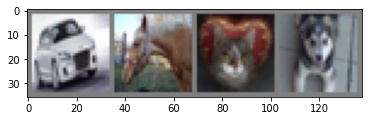

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    #첫번째 원소를 두번째, 두번째 원소를 마지막, 마지막 원소를 첫번째 위치로


# get some random training images
dataiter = iter(trainloader) #iter는 원하는 값이 나올 때 까지 특정대상을 계속 돌림
images, labels = dataiter.next() #iter 다음에는 next로 부름
print(images.shape) # 4개 짜리 미니배치, 이미지 사이즈는 (3,32,32)
print(labels) # y가 숫자로 되어있고 그 숫자를 부르는 것임. 그래서label[j]가 필요

# show images
imshow(torchvision.utils.make_grid(images))
#Make a grid of images.

#Args:
#    tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)  
#        or a list of images all of the same size.

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

  iter
iter는 반복을 끝낼 값을 지정하면 특정 값이 나올 때 반복을 끝냅니다. 이 경우에는 반복 가능한 객체 대신 호출 가능한 객체(callable)를 넣어줍니다. 참고로 반복을 끝낼 값은 sentinel이라고 부르는데 감시병이라는 뜻입니다. 즉, 반복을 감시하다가 특정 값이 나오면 반복을 끝낸다고 해서 sentinel입니다.

iter(호출가능한객체, 반복을끝낼값)
예를 들어 random.randint(0, 5)와 같이 0부터 5까지 무작위로 숫자를 생성할 때 2가 나오면 반복을 끝내도록 만들 수 있습니다. 이때 호출 가능한 객체를 넣어야 하므로 매개변수가 없는 함수 또는 람다 표현식으로 만들어줍니다.

## 2. Define a Convolution Neural Network

### mini VGG

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

      #(100,32,32,3)

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
            
        #(100,16,16,32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
      # (100, 8, 8, 64)  
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # (100, 4, 4, 128)


        self.fc1=torch.nn.Sequential(
            torch.nn.Linear(4* 4 * 128, 512, bias=True),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU())
        
        
        self.fc2=torch.nn.Sequential(
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.Dropout(0.5),
            torch.nn.ReLU())
        
        self.result_layer=torch.nn.Linear(512, 10, bias=True)
         
        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.normal_(self.result_layer.weight,std=0.01)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(-1,4*4*128)    # 전결합층을 위해서 Flatten
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.result_layer(out)
        return out

'''class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x '''


'class Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(3, 6, 5)\n        self.pool = nn.MaxPool2d(2, 2)\n        self.conv2 = nn.Conv2d(6, 16, 5)\n        self.fc1 = nn.Linear(16 * 5 * 5, 120)\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, 10)\n\n    def forward(self, x):\n        x = self.pool(F.relu(self.conv1(x)))\n        x = self.pool(F.relu(self.conv2(x)))\n        x = x.view(-1, 16 * 5 * 5)\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x '

### mini VGG + Full-Convolution

In [40]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

      #(32,32,3)

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
            
        #(100,16,16,32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
      # (100, 8, 8, 64)  
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # (100, 4, 4, 128)


        self.fc=torch.nn.Sequential(
            torch.nn.Conv2d(128, 10,kernel_size=4,stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(10,10,kernel_size=1,stride=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(10,10,kernel_size=1,stride=1),
            torch.nn.ReLU())
        
        self.resultlayer= torch.nn.Softmax()
      
      

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.fc(out)
        out= out.view(-1,10)
        out= self.resultlayer(out)
        return out


'''class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x '''


'class Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(3, 6, 5)\n        self.pool = nn.MaxPool2d(2, 2)\n        self.conv2 = nn.Conv2d(6, 16, 5)\n        self.fc1 = nn.Linear(16 * 5 * 5, 120)\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, 10)\n\n    def forward(self, x):\n        x = self.pool(F.relu(self.conv1(x)))\n        x = self.pool(F.relu(self.conv2(x)))\n        x = x.view(-1, 16 * 5 * 5)\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x '

## 3. Define a Loss function and optimizer

### Hyperparmeter


In [41]:
import torch.optim as optim

training_epochs=20
learning_rate=0.1
total_batch = len(trainloader)

In [42]:
# CNN 모델 정의
model = CNN().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)    # 비용 함수에 소프트맥스 함수 포함되어져 있음.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Training

In [43]:
print(f'총 Epochs 수 = {training_epochs}')
acc=[]
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in trainloader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y느 ㄴ레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X=X.to(device)
        Y=Y.to(device)
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        avg_cost += loss / total_batch
        
        y_pred = model.forward(X) # forward 연산
        correct_prediction = torch.argmax(y_pred, 1) == Y
        accuracy = correct_prediction.float().mean()

  #어차피 softmax 함수 결과값의 크기는 그전에 dot product의 크기와 비례하기 때문이다.
    acc.append(accuracy)
    print(f'[Epoch: {epoch+1}] / cost = {avg_cost} / accuracy = {accuracy}')

총 Epochs 수 = 20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch: 1] / cost = 2.3026769161224365 / accuracy = 0.25
[Epoch: 2] / cost = 2.3026480674743652 / accuracy = 0.0
[Epoch: 3] / cost = 2.3026046752929688 / accuracy = 0.0625
[Epoch: 4] / cost = 2.3025765419006348 / accuracy = 0.125
[Epoch: 5] / cost = 2.3025763034820557 / accuracy = 0.125
[Epoch: 6] / cost = 2.3025763034820557 / accuracy = 0.125
[Epoch: 7] / cost = 2.3025763034820557 / accuracy = 0.25
[Epoch: 8] / cost = 2.3025763034820557 / accuracy = 0.25
[Epoch: 9] / cost = 2.3025763034820557 / accuracy = 0.0
[Epoch: 10] / cost = 2.3025763034820557 / accuracy = 0.25
[Epoch: 11] / cost = 2.3025763034820557 / accuracy = 0.125
[Epoch: 12] / cost = 2.3025763034820557 / accuracy = 0.125
[Epoch: 13] / cost = 2.3025763034820557 / accuracy = 0.125
[Epoch: 14] / cost = 2.3025763034820557 / accuracy = 0.0625
[Epoch: 15] / cost = 2.3025763034820557 / accuracy = 0.0625
[Epoch: 16] / cost = 2.3025763034820557 / accuracy = 0.0
[Epoch: 17] / cost = 2.3025763034820557 / accuracy = 0.1875
[Epoch: 18] 

Let's use a Classification Cross-Entropy loss and SGD with momentum.

## 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


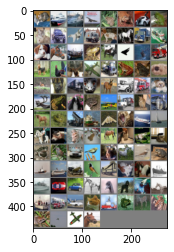

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat plane   car  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images=images.to(device)
        labels=labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(correct)
print(total)

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

7706
10000
Accuracy of the network on the 10000 test images: 77 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 84 %
Accuracy of   car : 87 %
Accuracy of  bird : 60 %
Accuracy of   cat : 67 %
Accuracy of  deer : 79 %
Accuracy of   dog : 68 %
Accuracy of  frog : 86 %
Accuracy of horse : 81 %
Accuracy of  ship : 85 %
Accuracy of truck : 79 %
